In [ ]:
# hướng dẫn sử dụng

# link tải file fer2013.csv
# https://www.kaggle.com/datasets/deadskull7/fer2013/data?select=fer2013.csv
# Sau khi tải xong , hãy để im file zip và đẩy lên mydrive tron gg drive của bạn

# lên gg colab  link : https://colab.research.google.com
# thực hiện import file .ipynb này vào gg colab
# Thực hiện chạy các đoạn code dưới để có thể có được tập train hoàn chỉnh với resnet18 trên tập fer2013

# ÁP DỤNG RESNET18 TRÊN TẬP FER2013 ĐÃ ĐƯỢC RANDOM TẠO ẢNH ÁNH SÁNG YẾU

## 1.Chuẩn bị dữ liệu

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/fer2013.csv.zip'  # thay bằng đường dẫn thật
extract_path = '/content/drive/MyDrive/csv'  # thư mục để lưu file sau khi giải nén

# Tạo thư mục nếu chưa tồn tại
os.makedirs(extract_path, exist_ok=True)

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Đã giải nén thành công!")


Đã giải nén thành công!


In [6]:
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageFilter

# ⚙️ Cấu hình
csv_path = '/content/drive/MyDrive/csv/fer2013.csv'
output_dir = 'FER2013_Images'

# Nhãn tương ứng với emotion
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# 📥 Đọc file CSV
df = pd.read_csv(csv_path)

# 📂 Tạo thư mục output nếu chưa có
for usage in df['Usage'].unique():
    for label in emotion_labels.values():
        os.makedirs(os.path.join(output_dir, usage, label), exist_ok=True)

# 🔄 Duyệt từng dòng và lưu ảnh
for i, row in df.iterrows():
    emotion = int(row['emotion'])
    pixels = list(map(int, row['pixels'].split()))
    usage = row['Usage']  # Training, PublicTest, PrivateTest

    # Chuyển thành ảnh 48x48
    image = np.array(pixels, dtype=np.uint8).reshape(48, 48)
    img = Image.fromarray(image)
    img = img.convert("RGB")  # để dùng ResNet cần ảnh RGB

    # Resize ảnh lên 224x224
    img_resized = img.resize((224, 224), resample=Image.BICUBIC)

    # Làm nét ảnh (Sharpening)
    sharpener = ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3)
    img_sharpened = img_resized.filter(sharpener)

    # Tên file ảnh
    label_name = emotion_labels[emotion]
    file_name = f"{i}.jpg"
    save_path = os.path.join(output_dir, usage, label_name, file_name)

    img_sharpened.save(save_path)

print("✅ Hoàn tất tạo ảnh từ CSV, resize ảnh lên 224x224 và làm nét ảnh!")


✅ Hoàn tất tạo ảnh từ CSV, resize ảnh lên 224x224 và làm nét ảnh!


## 2.Chuẩn bị thư viện

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet18_Weights
import copy
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance
import os
import numpy as np
import cv2
from skimage import exposure
import torchvision.models as models



## 3.Chuẩn bị tiền xử lí với các tập train , val , test

 ### 3.1 KĨ THUẬT RANDOM ẢNH BÌNH THƯỜNG SANG ĐK ÁNH SÁNG YẾU

In [60]:
def apply_gamma_correction(img, gamma):
    img = np.array(img).astype(np.float32) / 255.0
    img = np.power(img, gamma)
    img = np.clip(img * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(img)

def apply_random_gamma_darkening(img, min_gamma=1.5, max_gamma=2.5, prob=0.3):
    if random.random() > prob:
        return img
    gamma = random.uniform(min_gamma, max_gamma)
    return apply_gamma_correction(img, gamma)

### 3.2 Tạo tập dữ liệu train , val ,  test với kĩ thuật làm ảnh ánh sáng yếu

In [61]:
# 📦 Các cấu hình
IMG_SIZE = 224
BATCH_SIZE = 32

# ✅ Cập nhật lại đường dẫn đúng với cấu trúc thư mục của bạn
train_path = 'FER2013_Images/Training'
val_path = 'FER2013_Images/PrivateTest'
test_path = 'FER2013_Images/PublicTest'

# ✅ Các transform cho dữ liệu huấn luyện (có ảnh ánh sáng yếu ngẫu nhiên)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, shear=15, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Lambda(lambda img: apply_random_gamma_darkening(img, prob=0.5)),  # 💡 Làm tối ngẫu nhiên bằng gamma
    transforms.ToTensor()
])

# ✅ Các transform cho validation/test (nếu cũng muốn mô phỏng ảnh yếu sáng)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Lambda(lambda img: apply_random_gamma_darkening(img, prob=0.3)),  # 💡 tùy chọn, có thể bỏ nếu không muốn
    transforms.ToTensor()
])

# 📚 Load dataset
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=val_test_transform)

# 🚀 Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 🧮 In số lượng ảnh trong từng tập
print(f"Số lượng ảnh trong tập huấn luyện: {len(train_dataset)}")
print(f"Số lượng ảnh trong tập validation: {len(val_dataset)}")
print(f"Số lượng ảnh trong tập test: {len(test_dataset)}")


Số lượng ảnh trong tập huấn luyện: 28709
Số lượng ảnh trong tập validation: 3589
Số lượng ảnh trong tập test: 3589


## 4.Khởi tạo mô hình Resnet18

Mô hình đã đước train trước , ta chỉ việc sửa lại lớp fc cuối cùng để phù hợp với số lớp trong FER2013

In [62]:
# Khởi tạo mô hình ResNet18 với trọng số đã được huấn luyện trên ImageNet
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Sửa lại lớp fully connected cuối cùng để phù hợp với số lớp trong FER2013 (7 lớp)
model.fc = nn.Linear(model.fc.in_features, 7)

# Chuyển mô hình sang GPU (nếu có GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)


cuda


In [63]:
# Loss function (CrossEntropy cho phân loại đa lớp)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 5.Huấn luyện mô hình trên tập train , val



In [64]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

NUM_EPOCHS = 20
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
class_names = train_dataset.classes  # Tên các lớp

for epoch in range(NUM_EPOCHS):
    # ----- Train -----
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ----- Validation -----
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # 🧠 Kiểm tra và lưu mô hình tốt nhất
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"📌 Epoch {epoch+1}: Cập nhật mô hình tốt nhất với val_acc = {best_val_acc:.4f}")

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

📌 Epoch 1: Cập nhật mô hình tốt nhất với val_acc = 0.5414
Epoch [1/20] - Train Loss: 1.3654, Train Acc: 0.4798 - Val Loss: 1.2078, Val Acc: 0.5414
📌 Epoch 2: Cập nhật mô hình tốt nhất với val_acc = 0.5511
Epoch [2/20] - Train Loss: 1.1840, Train Acc: 0.5496 - Val Loss: 1.1635, Val Acc: 0.5511
📌 Epoch 3: Cập nhật mô hình tốt nhất với val_acc = 0.5979
Epoch [3/20] - Train Loss: 1.1208, Train Acc: 0.5735 - Val Loss: 1.0832, Val Acc: 0.5979
📌 Epoch 4: Cập nhật mô hình tốt nhất với val_acc = 0.6166
Epoch [4/20] - Train Loss: 1.0746, Train Acc: 0.5964 - Val Loss: 1.0233, Val Acc: 0.6166
📌 Epoch 5: Cập nhật mô hình tốt nhất với val_acc = 0.6236
Epoch [5/20] - Train Loss: 1.0436, Train Acc: 0.6075 - Val Loss: 0.9887, Val Acc: 0.6236
📌 Epoch 6: Cập nhật mô hình tốt nhất với val_acc = 0.6450
Epoch [6/20] - Train Loss: 1.0066, Train Acc: 0.6175 - Val Loss: 0.9779, Val Acc: 0.6450
📌 Epoch 7: Cập nhật mô hình tốt nhất với val_acc = 0.6539
Epoch [7/20] - Train Loss: 0.9815, Train Acc: 0.6287 - Val L

## 6. Lưu lại mô hình tốt nhất

In [65]:
# 🔒 Lưu mô hình tốt nhất
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "RESTNET18-V4.pth")
print("✅ Đã lưu mô hình tốt nhất vào file:" + "RESTNET18-V4.pth")

✅ Đã lưu mô hình tốt nhất vào file:RESTNET18-V4.pth


## 7. Chạy mô hình tốt nhất trên tập test

cho ra các minh chứng :
- confusion matrix
- classification report
- accuracy score

🎯 Độ chính xác trên tập test: 0.6704

📋 Classification Report:
              precision    recall  f1-score   support

       Angry       0.60      0.59      0.59       467
     Disgust       0.61      0.48      0.54        56
        Fear       0.59      0.45      0.51       496
       Happy       0.89      0.84      0.87       895
     Neutral       0.53      0.75      0.62       607
         Sad       0.60      0.49      0.54       653
    Surprise       0.75      0.85      0.80       415

    accuracy                           0.67      3589
   macro avg       0.65      0.64      0.64      3589
weighted avg       0.68      0.67      0.67      3589



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


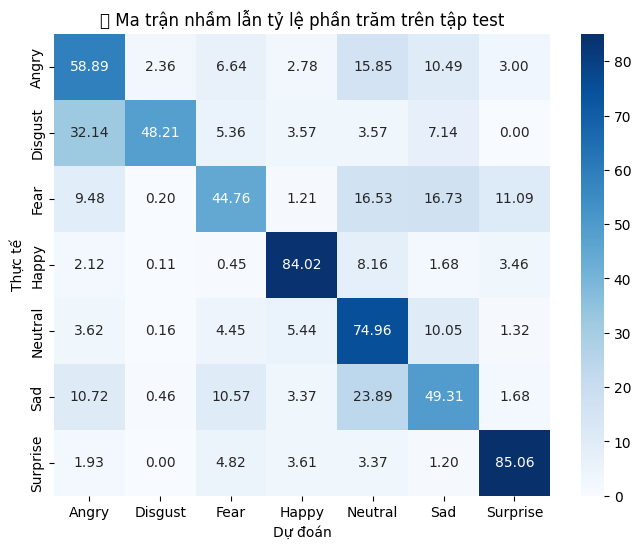

In [67]:
# Load lại trọng số mô hình tốt nhất
model_path = "RESTNET18-V4.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 🎯 Accuracy tổng thể
test_acc = accuracy_score(all_labels, all_preds)
print(f"🎯 Độ chính xác trên tập test: {test_acc:.4f}")

# 📋 Classification report
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# 📊 Ma trận nhầm lẫn
conf_mat = confusion_matrix(all_labels, all_preds)

# Tính tỷ lệ phần trăm trên từng nhãn
conf_mat_percentage = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_percentage, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("📊 Ma trận nhầm lẫn tỷ lệ phần trăm trên tập test")
plt.show()


## 8.Kích thước mô hình

In [68]:
file_path = "RESTNET18-V4.pth"
file_size = os.path.getsize(file_path)  # tính bằng byte
print(f"Kích thước mô hình: {file_size / (1024 * 1024):.2f} MB")

Kích thước mô hình: 42.72 MB


## 9.Thời gian suy luận trung bình 1 ảnh

In [71]:
import time

# Load lại trọng số mô hình tốt nhất
model_path = "RESTNET18-V4.pth"
model.load_state_dict(torch.load(model_path))
model.eval()
num_images = 0
total_time = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)

        start_time = time.time()
        outputs = model(inputs)
        end_time = time.time()

        total_time += (end_time - start_time)
        num_images += inputs.size(0)  # số ảnh trong batch

avg_inference_time = total_time / num_images
print(f"⏱️ Thời gian suy luận trung bình: {avg_inference_time * 1000:.2f} ms/ảnh")


⏱️ Thời gian suy luận trung bình: 3.18 ms/ảnh


## 10. Grad Cam

Xác định vùng trên khuôn mặt được sử dụng để nhận dạng cảm xúc

## 10.1 Load lại model đã được train

In [72]:
# Tạo lại model ResNet18 và sửa lớp FC cho FER2013 (7 lớp cảm xúc)
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load("RESTNET18-V4.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## -- CÀI ĐẶT THƯ VIỆN GRAD_CAM

In [18]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s 

## 10.2 Chạy Grad Cam với 7 cảm xúc trong tập test

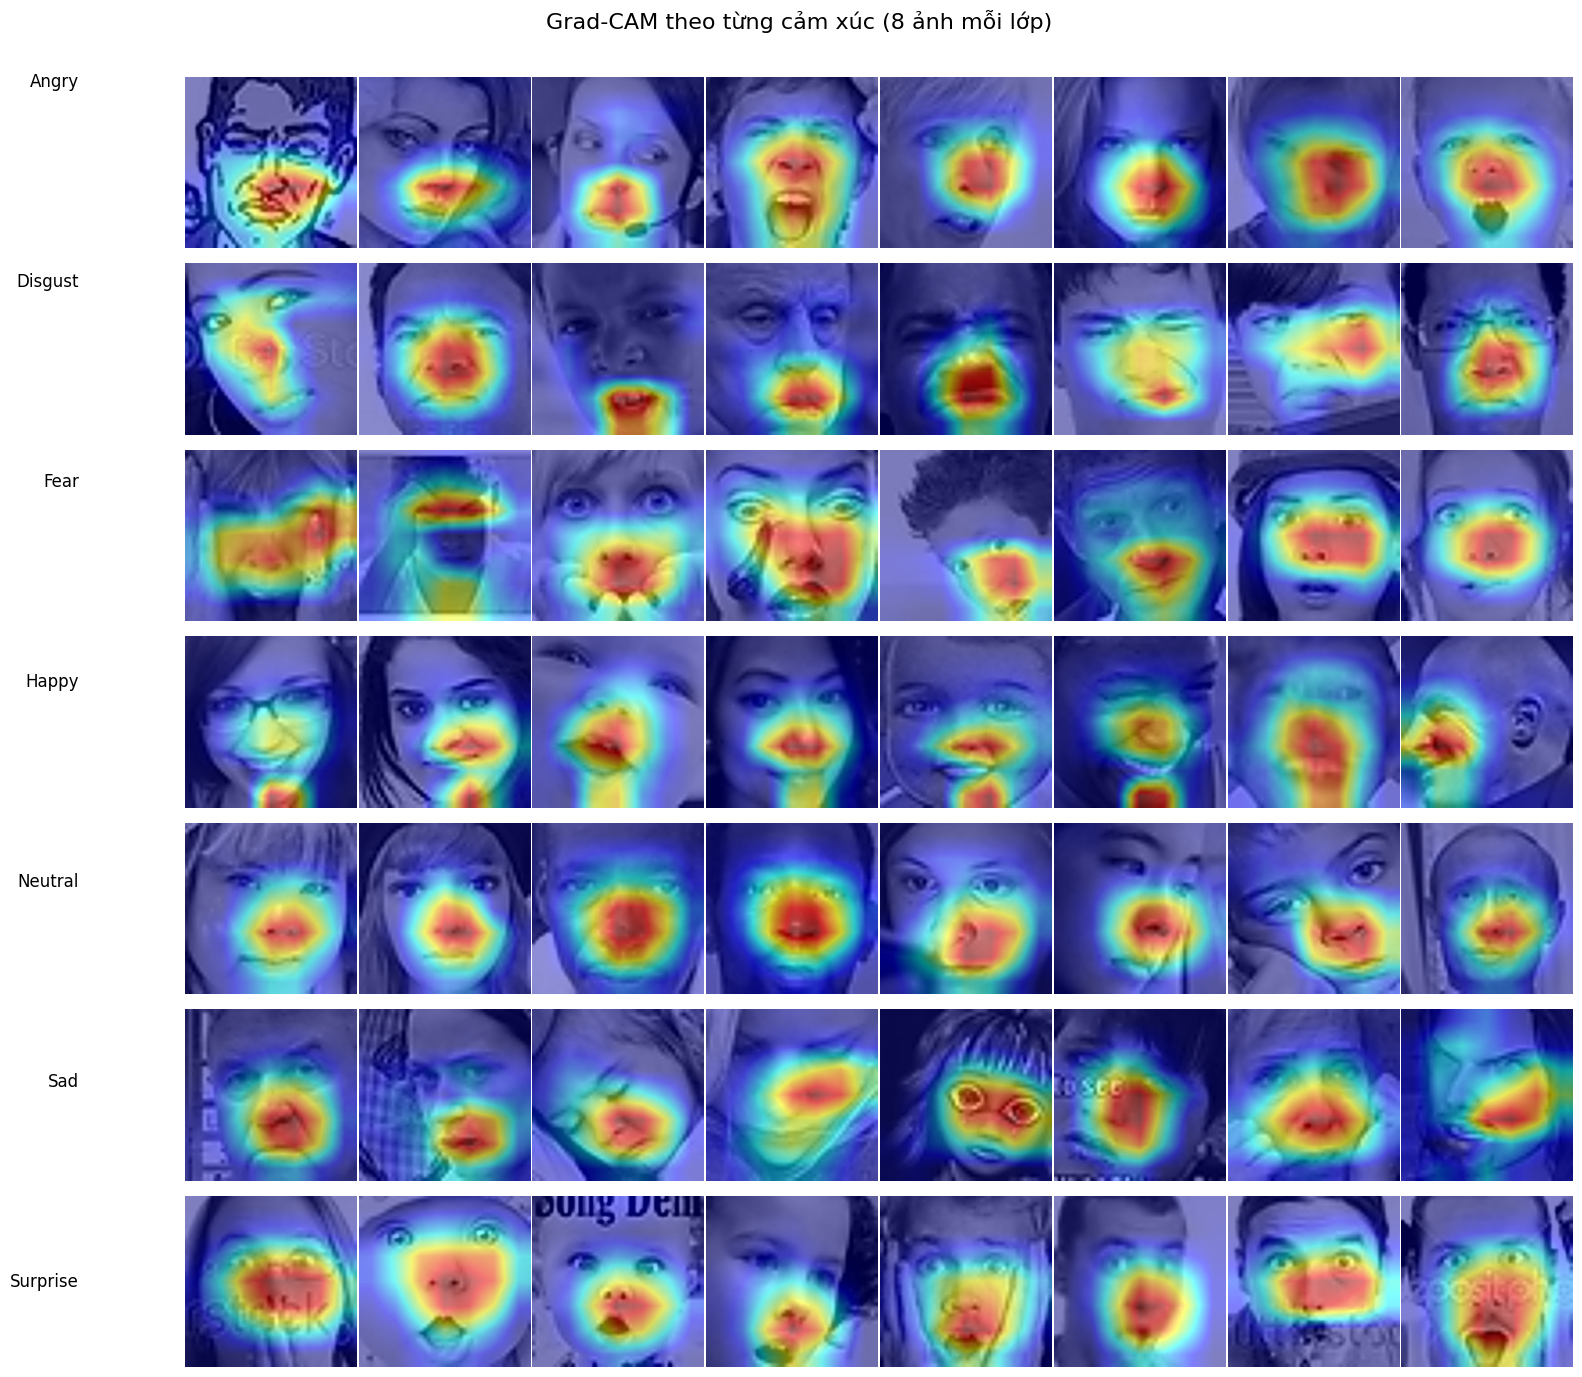

In [73]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# ✅ Cấu hình đường dẫn và lớp cảm xúc
data_root = "FER2013_Images/PublicTest"
emotion_classes = sorted(os.listdir(data_root))  # ['Angry', 'Disgust', ...]

# ✅ Chuẩn bị model, lớp cuối, transform
target_layer = model.layer4[-1]
cam = GradCAM(model=model, target_layers=[target_layer])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
model.eval()
model.to(device)

# ✅ Tạo figure với 7 hàng, mỗi hàng 8 ảnh
num_images_per_class = 8
fig, axes = plt.subplots(len(emotion_classes), num_images_per_class, figsize=(16, 14))
fig.subplots_adjust(hspace=0.4, wspace=0.05, left=0.12)

for i, emotion in enumerate(emotion_classes):
    emotion_path = os.path.join(data_root, emotion)
    image_files = sorted([f for f in os.listdir(emotion_path) if f.endswith(('.jpg', '.png'))])[:num_images_per_class]

    for j, img_name in enumerate(image_files):
        img_path = os.path.join(emotion_path, img_name)
        img = Image.open(img_path).convert("RGB")

        input_tensor = transform(img).unsqueeze(0).to(device)

        # Grad-CAM
        with torch.no_grad():
            outputs = model(input_tensor)
        pred_class = outputs.argmax().item()

        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]
        rgb_img = np.array(img.resize((224, 224))) / 255.0
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        axes[i, j].imshow(cam_image)
        axes[i, j].axis('off')

# ✅ Thêm tên hàng bên trái (trung tâm từng dòng)
for i, emotion in enumerate(emotion_classes):
    fig.text(0.05, 1 - (i + 0.5) / len(emotion_classes), emotion, va='center', ha='right', fontsize=12)

plt.suptitle("Grad-CAM theo từng cảm xúc (8 ảnh mỗi lớp)", fontsize=16)
plt.tight_layout(rect=[0.1, 0, 1, 0.97])  # chừa chỗ cho label bên trái và tiêu đề trên
plt.show()
